# Association Rule Mining of Emergency 911 Calls

### Preprocessing and EDA of 911 emergency call data.
Download the dataset here: https://www.kaggle.com/datasets/mchirico/montcoalert

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

In [5]:
data = pd.read_csv('../911.csv')
print(data.shape)
data.head()

(663522, 9)


,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


Our data has 663522 objects with 9 attributes.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


We have latitude, longitude, and ZIP code as our float values, the emergency description (desc), the title of the emergency, the date/time (timeStamp), the township (twp) and the general address (addr) are object values. The index e is actually always 1 for this dataset, and prior reading of this dataset's reference material shows that it is not needed for our analysis. We're going to preprocess this according to https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/ with a focus on generalizable features as specified in https://www.geeksforgeeks.org/project-idea-analysis-emergency-911-calls-using-association-rule-mining/.

In [7]:
data['title'].value_counts()

Traffic: VEHICLE ACCIDENT -    148372
Traffic: DISABLED VEHICLE -     47909
Fire: FIRE ALARM                38336
EMS: FALL VICTIM                34676
EMS: RESPIRATORY EMERGENCY      34248
                                ...  
EMS: DISABLED VEHICLE               1
Fire: PRISONER IN CUSTODY           1
Fire: GENERAL WEAKNESS              1
Fire: SUSPICIOUS                    1
Fire: BARRICADED SUBJECT            1
Name: title, Length: 148, dtype: int64

Lets split this information into two separate columns and then remove the 'e' column

In [8]:
data = data.drop(['e'],axis=1)
data['service'] = data["title"].apply(lambda x: x.split(':')[0])
data['type'] = data["title"].apply(lambda x: x.split(':')[1])
print(data['service'].value_counts(), '\n', data['type'].value_counts())

EMS        332692
Traffic    230208
Fire       100622
Name: service, dtype: int64 
  VEHICLE ACCIDENT -     148372
 DISABLED VEHICLE -      47909
 FIRE ALARM              38452
 VEHICLE ACCIDENT        36377
 FALL VICTIM             34683
                         ...  
 ROAD OBSTRUCTION            2
 HIT + RUN                   1
 PRISONER IN CUSTODY         1
 FOOT PATROL                 1
 ANIMAL COMPLAINT            1
Name: type, Length: 95, dtype: int64


We need to coerce some values to be the same, like VEHICLE ACCIDENT

In [9]:
data['type'] = data['type'].str.strip()
data['type'] = data['type'].str.replace(' -', '')
data['type'].value_counts

<bound method IndexOpsMixin.value_counts of 0          BACK PAINS/INJURY
1         DIABETIC EMERGENCY
2              GAS-ODOR/LEAK
3          CARDIAC EMERGENCY
4                  DIZZINESS
                 ...        
663517      VEHICLE ACCIDENT
663518      GENERAL WEAKNESS
663519      VEHICLE ACCIDENT
663520         BUILDING FIRE
663521      VEHICLE ACCIDENT
Name: type, Length: 663522, dtype: object>

In [10]:
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,service,type
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,EMS,DIABETIC EMERGENCY
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,Fire,GAS-ODOR/LEAK
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,EMS,CARDIAC EMERGENCY
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,EMS,DIZZINESS


Let's change the continuous timeStamp attribute into a discrete attribute for better generalizability. We can use the season of the year and the time of day.

In [11]:
data['timeStamp'] = pd.to_datetime(data['timeStamp'])

In [12]:
def assign_season(month): #Divide evenly into 4 seasons
    if month in [12,1,2]:
        return 'winter'
    elif month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    else:
        return 'fall'
data['season'] = data['timeStamp'].apply(lambda x: assign_season(x.month))

In [13]:
def assign_tod(hour): #Divide somewhat evenly into 4 times of day
    if hour in [0,1,2,3,4,5]:
        return 'night'
    elif hour in [6,7,8,9,10,11]:
        return 'morning'
    elif hour in [12,13,14,15,16]:
        return 'afternoon'
    elif hour in [17,18,19,20,21]:
        return 'evening'
    
data['time_of_day'] = data['timeStamp'].apply(lambda x: assign_tod(x.hour))

In [14]:
def assign_weekend(day):
    if day in [5,6]:
        return 'weekend'
    else:
        return 'weekday'
data['time_of_week'] = data['timeStamp'].apply(lambda x: assign_weekend(x.dayofweek))

In [15]:
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,service,type,season,time_of_day,time_of_week
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY,winter,evening,weekday
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,EMS,DIABETIC EMERGENCY,winter,evening,weekday
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,Fire,GAS-ODOR/LEAK,winter,afternoon,weekday
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,EMS,CARDIAC EMERGENCY,winter,afternoon,weekday
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,EMS,DIZZINESS,winter,afternoon,weekday


Great, now we have some discrete attributes to use with our labels. Now let's take a look at our other attributes to see if anything meaningful is in them.

In [16]:
#print first 5 descriptions
for n in range(5):
    print(data['desc'][n])

REINDEER CT & DEAD END;  NEW HANOVER; Station 332; 2015-12-10 @ 17:10:52;
BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP; Station 345; 2015-12-10 @ 17:29:21;
HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-Station:STA27;
AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A; 2015-12-10 @ 16:47:36;
CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; Station 329; 2015-12-10 @ 16:56:52;


In [17]:
print(data['addr'].nunique())
print(data['zip'].nunique())
print(data['twp'].nunique())

41292
204
68


In [18]:
data['zip'] = data['zip'].astype(str).str[:5]
data['twp'] = data['twp'].astype(str).str.upper()
print(data['zip'].nunique())
print(data['twp'].nunique())

205
69


In [19]:
data['type'].value_counts()


VEHICLE ACCIDENT         184749
DISABLED VEHICLE          47917
FIRE ALARM                38452
FALL VICTIM               34683
RESPIRATORY EMERGENCY     34250
                          ...  
ARMED SUBJECT                 2
ANIMAL COMPLAINT              1
PRISONER IN CUSTODY           1
HIT + RUN                     1
FOOT PATROL                   1
Name: type, Length: 88, dtype: int64

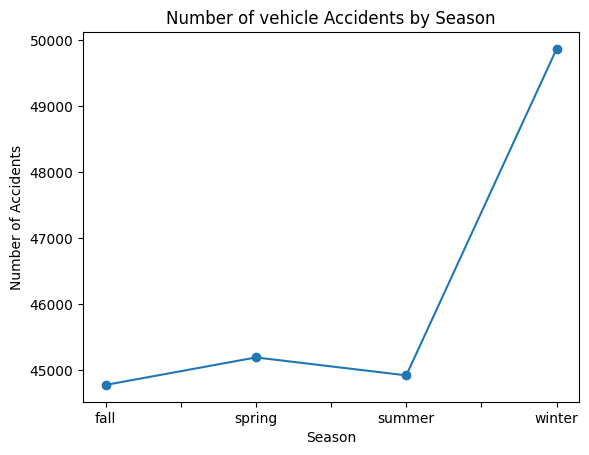

In [20]:
season_counts = data[data['type'] == 'VEHICLE ACCIDENT'].groupby('season').size()
season_counts.plot(kind='line', marker='o')
plt.xlabel('Season')
plt.ylabel('Number of Accidents')
plt.title('Number of vehicle Accidents by Season')
plt.show()


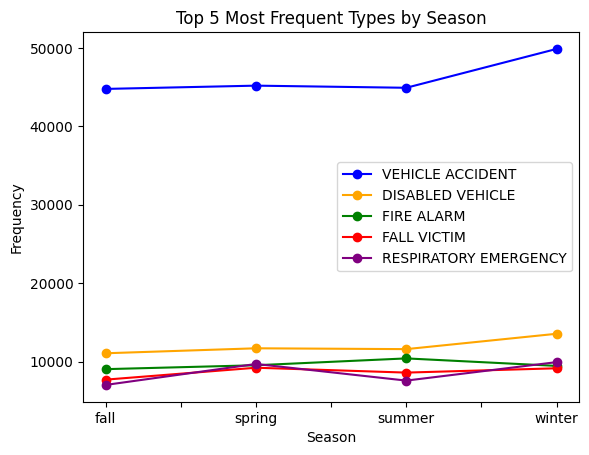

In [21]:
import matplotlib.pyplot as plt

top_5_types = data['type'].value_counts().head(5).index

colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define colors for each type

for i, type_ in enumerate(top_5_types):
    type_counts = data[data['type'] == type_]['season'].value_counts().sort_index()
    type_counts.plot(kind='line', marker='o', label=type_, color=colors[i])  # Use color from the defined list

plt.xlabel('Season')  # Change x-axis label to 'Season'
plt.ylabel('Frequency')
plt.title('Top 5 Most Frequent Types by Season')
plt.legend()
plt.show()

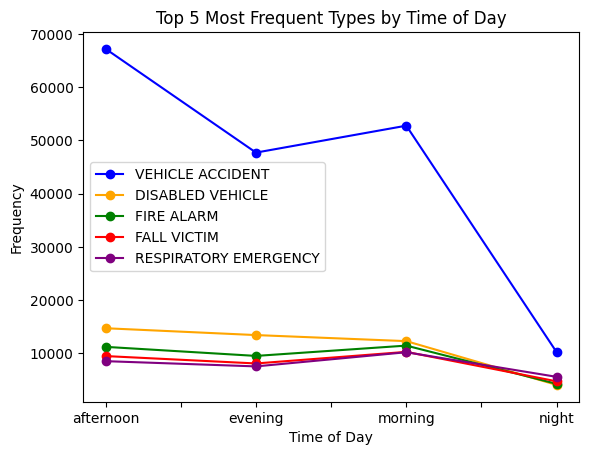

In [22]:
import matplotlib.pyplot as plt

top_5_types = data['type'].value_counts().head(5).index

colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define colors for each type

for i, type_ in enumerate(top_5_types):
    type_counts = data[data['type'] == type_]['time_of_day'].value_counts().sort_index()
    type_counts.plot(kind='line', marker='o', label=type_, color=colors[i])  # Use color from the defined list

plt.xlabel('Time of Day')  # Change x-axis label to 'Season'
plt.ylabel('Frequency')
plt.title('Top 5 Most Frequent Types by Time of Day')
plt.legend()
plt.show()

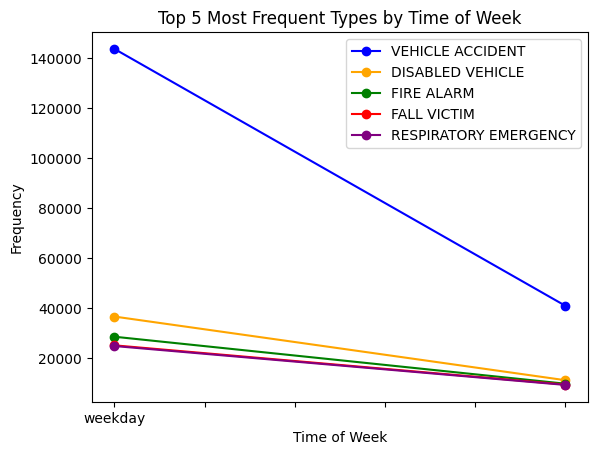

In [23]:
import matplotlib.pyplot as plt

top_5_types = data['type'].value_counts().head(5).index

colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define colors for each type

for i, type_ in enumerate(top_5_types):
    type_counts = data[data['type'] == type_]['time_of_week'].value_counts().sort_index()
    type_counts.plot(kind='line', marker='o', label=type_, color=colors[i])  # Use color from the defined list

plt.xlabel('Time of Week')  # Change x-axis label to 'Season'
plt.ylabel('Frequency')
plt.title('Top 5 Most Frequent Types by Time of Week')
plt.legend()
plt.show()

In [ ]:
data = data.dropna()
data.shape
data.to_csv('data.csv', index=False)

: 

Our results imply that we should see more accidents happen during the winter, and more overall emergencies in the afternoon. We also expect more call during the week as opposed to weekends.

Access the data.csv file and perform the Apriori algorithm. The goals is to constrain this to discrete labels, so use the columns specified in this notebook. You should download the compressed file from Git, unzip it, and then use it in your code. You may need to convert the data types to `str`.